# Regression Model to determine influence of artist's gender on the topics generated by BERTopic

In [ ]:
from google.colab import drive
import os

# gdrive_path='/content/gdrive/MyDrive/Bertopic/shared_work/'

# # This will mount your google drive under 'MyDrive'
# drive.mount('/content/gdrive', force_remount=True)
# # In order to access the files in this notebook we have to navigate to the correct folder
# os.chdir(gdrive_path)
# dataset_path = ''
# # Check manually if all files are present
# print(sorted(os.listdir()))

# To run from the common drive:
# dataset_path = '/content/drive/MyDrive/Praktikum - NLP Applications/Models/bertopic_concatenated_chunks_stratified'
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/gdrive
['BERTopic.ipynb', 'BERTopic_female.ipynb', 'Data-PreProcessing.ipynb', 'Dataset_Statistics.ipynb', 'Regression.ipynb', 'Regression_RapSubset.ipynb', 'Regression_RapSubset_stratified.ipynb', 'betti2023_weat_wordsets.csv', 'chunk_5.csv', 'chunk_6.csv', 'concatenated_chunks.csv', 'genius_with_artists_first_chunk.csv', 'glove.6B.100d.txt', 'glove.6B.100d.txt.word2vec', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.6B.50d.txt', 'glove.6B.zip', 'model', 'model_new', 'my_model', 'mymodel', 'scweat_analysis (1).ipynb', 'topics.json', 'topics.pkl', 'topics_for_bias_analysis.csv', 'updated_artists_with_gender_lyrics.csv', 'wasabi_artist_new_dartists.csv', 'wasabi_english_songs.csv', 'wasabi_new_dartists_balanced.csv', 'wasabi_new_songs_english_balanced_artists.csv', 'weat_results.csv']


In [ ]:
import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer
# from bertopic import BERTopic
# from umap import UMAP

# set path of the file
# csv_file_path = 'topics_for_bias_analysis.csv'
# df = pd.read_csv(dataset_path + csv_file_path)

In [ ]:
dataset = df[['genre', 'year', 'gender', 'topic', 'topic_label', 'topic_prob']]

In [ ]:
dataset.describe()

,year,topic,topic_prob
count,537553.000000,537553.000000,537553.000000
mean,2002.695682,165.225821,0.684348
std,23.488690,156.126712,0.093572
min,1.000000,-1.000000,0.050249
25%,1996.000000,28.000000,0.630626
50%,2008.000000,110.000000,0.693565
75%,2015.000000,269.000000,0.746582
max,2023.000000,541.000000,0.995553


In [ ]:
# Converting year to decade
dataset['year'].unique()

array([2004, 1998, 2002, 2009, 2000, 2006, 2010, 2011, 2003, 2014, 2007,
       2005, 1999, 2013, 2015, 2008, 2001, 2020, 2012, 2016, 2019, 1995,
       1994, 1997, 1993, 2017, 1992, 1996, 1988, 1990, 1991, 1960, 2018,
       1989, 1965, 1975, 1962, 1974, 1964, 1963, 1976, 1966, 1967, 1985,
       1979, 1986, 1961, 1981, 1980, 1978, 1969, 1970, 1971, 1968, 1973,
       1983, 1987, 1972, 1977, 1982, 2022, 1984, 2021, 1956,    1, 1950,
       1953, 1951, 1949, 1958, 1955, 1957, 1946, 1959, 1954, 1952, 1945,
       1948, 1947, 1939, 1871, 1876, 1865, 1415, 2023, 1770, 1944, 1855,
       1936,   15, 1814, 1759, 1785, 1788, 1789, 1791, 1782, 1929, 1938,
       1926, 1931, 1776, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808,
       1940, 1941, 1932, 1933, 1943, 1942,    2,  699, 1861, 1937, 1935,
       1934, 1862, 1918, 1919, 1917, 1930, 1517, 1790, 1787, 1928, 1927,
       1895, 1907, 1911, 1925, 1906, 1904, 1923,   79, 1864, 1847, 1921,
       1741, 1920, 1905, 1870, 1924, 1922, 1739, 17

In [ ]:
# Number of songs with year < 1950 - a few of these are from the 18th and 19th centuries but there are also some mistagged songs

print(len(dataset[dataset['year'] < 1950])) # => 2856, only 0.5% of the data so these are ignored
dataset = dataset[dataset['year'] >= 1950]

def get_decade(year):
  if year >= 2000 and year < 2010:
    decade = '2000s'
  else:
    decade = str(year//100) + str(year%100)[0] + '0s'
  return decade

dataset['decade'] = dataset['year'].apply(get_decade)

2856


In [ ]:
# Number of outliers

len(df[df['topic'] == -1])

8598

In [ ]:
dataset = dataset[dataset['topic'] != -1]
dataset = dataset[dataset['genre'] == 'rap']
top10topics = dataset['topic'].value_counts().nlargest(10).to_dict()
dataset['decade'] = dataset['year'].apply(get_decade)
mask = dataset['topic'].isin(top10topics)
top10 = dataset[mask]

In [ ]:
# Counting the number of entries with gender as 'male'
male_count = top10[top10['gender'] == 'Male'].shape[0]

print(f"Number of entries with gender male: {male_count}")

# Counting the number of entries with gender as 'Female'
Female_count = top10[top10['gender'] == 'Female'].shape[0]

print(f"Number of entries with gender Female: {Female_count}")

Number of entries with gender male: 54474
Number of entries with gender Female: 2389


In [ ]:
def get_balanced_data(gender_group):
    female_data = gender_group[gender_group['gender'] == 'Female']
    male_data = gender_group[gender_group['gender'] == 'Male']
    # We will use all female data
    female_count = female_data.shape[0]
    # Sample male data to match the number of female entries
    # If there are not enough male entries, we take what is available.
    # This will result in an imbalance if male_count < female_count.
    sampled_males = male_data.sample(n=min(female_count, male_data.shape[0]), random_state=1)
    return pd.concat([female_data, sampled_males])

# Apply the function to balance each decade's data
balanced_dataset = dataset.groupby('decade').apply(get_balanced_data).reset_index(drop=True)

# Now you can check the balance for each decade
for decade in balanced_dataset['decade'].unique():
    female_count = balanced_dataset[(balanced_dataset['decade'] == decade) & (balanced_dataset['gender'] == 'Female')].shape[0]
    male_count = balanced_dataset[(balanced_dataset['decade'] == decade) & (balanced_dataset['gender'] == 'Male')].shape[0]
    print(f"Decade: {decade} - Female: {female_count}, Male: {male_count}")

Decade: 1950s - Female: 2, Male: 2
Decade: 1960s - Female: 3, Male: 3
Decade: 1970s - Female: 5, Male: 5
Decade: 1980s - Female: 72, Male: 72
Decade: 1990s - Female: 550, Male: 550
Decade: 2000s - Female: 1261, Male: 1261
Decade: 2010s - Female: 2465, Male: 2465
Decade: 2020s - Female: 359, Male: 359


In [ ]:
balanced_dataset = balanced_dataset[balanced_dataset['topic'] != -1]
balanced_dataset = balanced_dataset[balanced_dataset['genre'] == 'rap']
top10topics = balanced_dataset['topic'].value_counts().nlargest(10).to_dict()
balanced_dataset['decade'] = balanced_dataset['year'].apply(get_decade)
mask = balanced_dataset['topic'].isin(top10topics)
top10 = balanced_dataset[mask]

In [ ]:
# Assuming 'top10' is your filtered DataFrame with the top 10 topics.

# Add decade column if not already present
top10['decade'] = top10['year'].apply(lambda x: (x // 10) * 10)

# Group by 'decade' and 'gender' and then count the number of occurrences
gender_counts_by_decade = top10.groupby(['decade', 'gender']).size().unstack(fill_value=0)

# Print the counts for each gender for each decade
for decade, counts in gender_counts_by_decade.iterrows():
    male_count = counts.get('Male', 0)
    female_count = counts.get('Female', 0)
    print(f"Decade: {decade}")
    print(f"Number of entries with gender male: {male_count}")
    print(f"Number of entries with gender Female: {female_count}")
    print()  # For better readability


Decade: 1950
Number of entries with gender male: 1
Number of entries with gender Female: 0

Decade: 1980
Number of entries with gender male: 30
Number of entries with gender Female: 34

Decade: 1990
Number of entries with gender male: 378
Number of entries with gender Female: 306

Decade: 2000
Number of entries with gender male: 810
Number of entries with gender Female: 682

Decade: 2010
Number of entries with gender male: 1499
Number of entries with gender Female: 1215

Decade: 2020
Number of entries with gender male: 178
Number of entries with gender Female: 186



<ipython-input-60-bcf47c869d51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['decade'] = top10['year'].apply(lambda x: (x // 10) * 10)


In [ ]:
# Step 1: Create the mapping dictionary
topic_to_label = dict(zip(df['topic'], df['topic_label']))
# Removing duplicates
topic_to_label = {k: v for k, v in topic_to_label.items() if pd.notnull(k)}

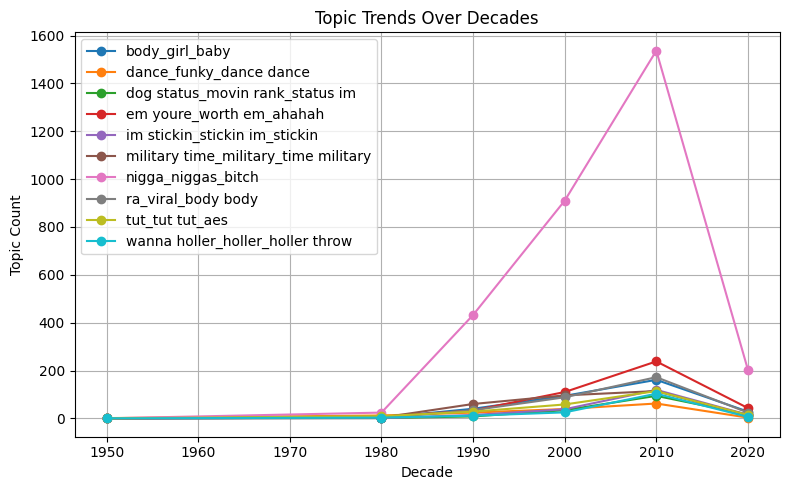

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

topic_trends = top10.groupby(['decade', 'topic_label']).size().unstack(fill_value=0)

plt.figure(figsize=(8, 5))
for topic in topic_trends.columns.unique():
    plt.plot(topic_trends.index, topic_trends[topic], marker='o', label=topic)

plt.title('Topic Trends Over Decades')
plt.xlabel('Decade')
plt.ylabel('Topic Count')
plt.legend(loc='best')  # You can adjust the location of the legend as needed
plt.grid(True)
plt.tight_layout()  # Adjust the plot to fit into the figure area nicely
plt.show()


In [ ]:
top10_X = top10[['decade', 'gender']]
top10_y = top10['topic']

In [ ]:
top10_y.unique()

array([  3, 101,   0, 261,  98,   2, 357,  66, 272, 398])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(top10_X, top10_y, test_size=0.2, random_state=42)

In [ ]:
len(top10_y.unique())

10

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define a set of parameters for tuning
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'penalty': ['l1', 'l2'],  # Type of penalty
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],  # Optimization algorithms
# }
# # Create the Logistic Regression model
# model = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')

# # Create GridSearchCV with the model and parameter grid
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # The best hyperparameters from GridSearchCV
# print("Best Parameters: ", grid_search.best_params_)

# # Use the best model
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)
# # Make predictions with the best model
# y_hat = best_model.predict(X_test)
# accuracy_score(y_hat, y_test)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
X_train, X_test, y_train, y_test = train_test_split(top10_X, top10_y, test_size=0.2, random_state=42)

# le = LabelEncoder()
cat = OneHotEncoder()
# cat_dec = OneHotEncoder()

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat, ['decade', 'gender'])
])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='saga',penalty= 'l1', max_iter=10000)

In [ ]:
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_hat, y_test)

0.5827067669172933

In [ ]:
import numpy as np

# Retrieve the model's coefficients for all classes
coefficients = model.coef_

# Calculate the average of the absolute values of the coefficients for each feature across all classes
mean_coefficients = np.mean(np.abs(coefficients), axis=0)

# Get feature names after OneHotEncoding
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['decade', 'gender'])

# Match averaged coefficients with feature names
feature_importance_dict = dict(zip(feature_names, mean_coefficients))

# Print sorted by absolute importance
sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# note: this code gives the importance of each feature, regardless of each class
# the coefficient here are all kinds positive because it is accross all classes, so more or less every feature would contribute if you every it out

decade_1980: 0.3298304732083935
gender_Male: 0.3085616595454275
decade_2020: 0.2734054704569578
decade_2010: 0.24953613757979504
gender_Female: 0.20993934466508613
decade_1990: 0.18867462317628875
decade_2000: 0.06051953414579782
decade_1950: 0.0


Positive Coefficients (Positive Influence):

A positive coefficient for a feature (like a specific decade or gender) means that the presence of this feature increases the probability of the model predicting a particular topic.
For example, if decade_1990s has a positive coefficient for Topic 3, it suggests that when a data point is from the 1990s, it is more likely to be
classified as Topic 3 compared to other topics.

Negative Coefficients (Negative Influence):
Conversely, a negative coefficient means that the feature decreases the probability of the model predicting a certain topic.
For instance, if decade_1970s has a negative coefficient for Topic 5, it implies that data points from the 1970s are less likely to be classified as Topic 5.

In [ ]:
# Retrieve the model's coefficients for all classes
coefficients = model.coef_

# Get feature names after OneHotEncoding
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['decade', 'gender'])

# Extract unique class names (topics) from y_train
class_names = y_train.unique()
class_names.sort()  # Sorting to ensure the order matches the class indices

# Step 1: Create the mapping dictionary
topic_to_label = dict(zip(df['topic'], df['topic_label']))
# Removing duplicates
topic_to_label = {k: v for k, v in topic_to_label.items() if pd.notnull(k)}


# Ensure the number of class names matches the number of classes in the model
assert len(class_names) == coefficients.shape[0], "Number of class names does not match number of classes"

for class_index in range(len(class_names)):
    # Get the coefficients for this class
    class_coefficients = coefficients[class_index]

    # Match coefficients with feature names for this class
    feature_importance_dict = dict(zip(feature_names, class_coefficients))

    # Get the topic label for the current class index
    topic_label = topic_to_label.get(class_names[class_index])

    # Print sorted by absolute importance
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: abs(item[1]), reverse=True)

    print(f"Feature Importances for Topic '{class_names[class_index]}', '{topic_label}':")
    for feature, importance in sorted_importances:
        print(f"{feature}: {importance}")
    print("\n")

Feature Importances for Topic '0', 'nigga_niggas_bitch':
decade_1990: 0.42278179881883793
decade_2000: 0.24347590952638548
gender_Male: 0.24136651628652428
decade_2020: -0.011275033475942609
decade_1950: 0.0
decade_1980: 0.0
decade_2010: 0.0
gender_Female: 0.0


Feature Importances for Topic '2', 'body_girl_baby':
gender_Male: -0.5944183272436193
gender_Female: 0.4933233569405486
decade_2010: -0.22940556760571576
decade_1950: 0.0
decade_1980: 0.0
decade_1990: 0.0
decade_2000: 0.0
decade_2020: 0.0


Feature Importances for Topic '3', 'dance_funky_dance dance':
decade_1980: 1.6899522605937796
decade_2020: -1.3587178430858162
gender_Male: -0.9605370455641351
decade_2010: -0.4657305290834326
decade_1990: 0.2310989471515048
decade_2000: -0.17782962381182882
decade_1950: 0.0
gender_Female: 0.0


Feature Importances for Topic '66', 'ra_viral_body body':
gender_Male: -0.24097532165369348
gender_Female: 0.2013214050258827
decade_2000: 0.11410250226528781
decade_1990: -0.11038365187905282
decade

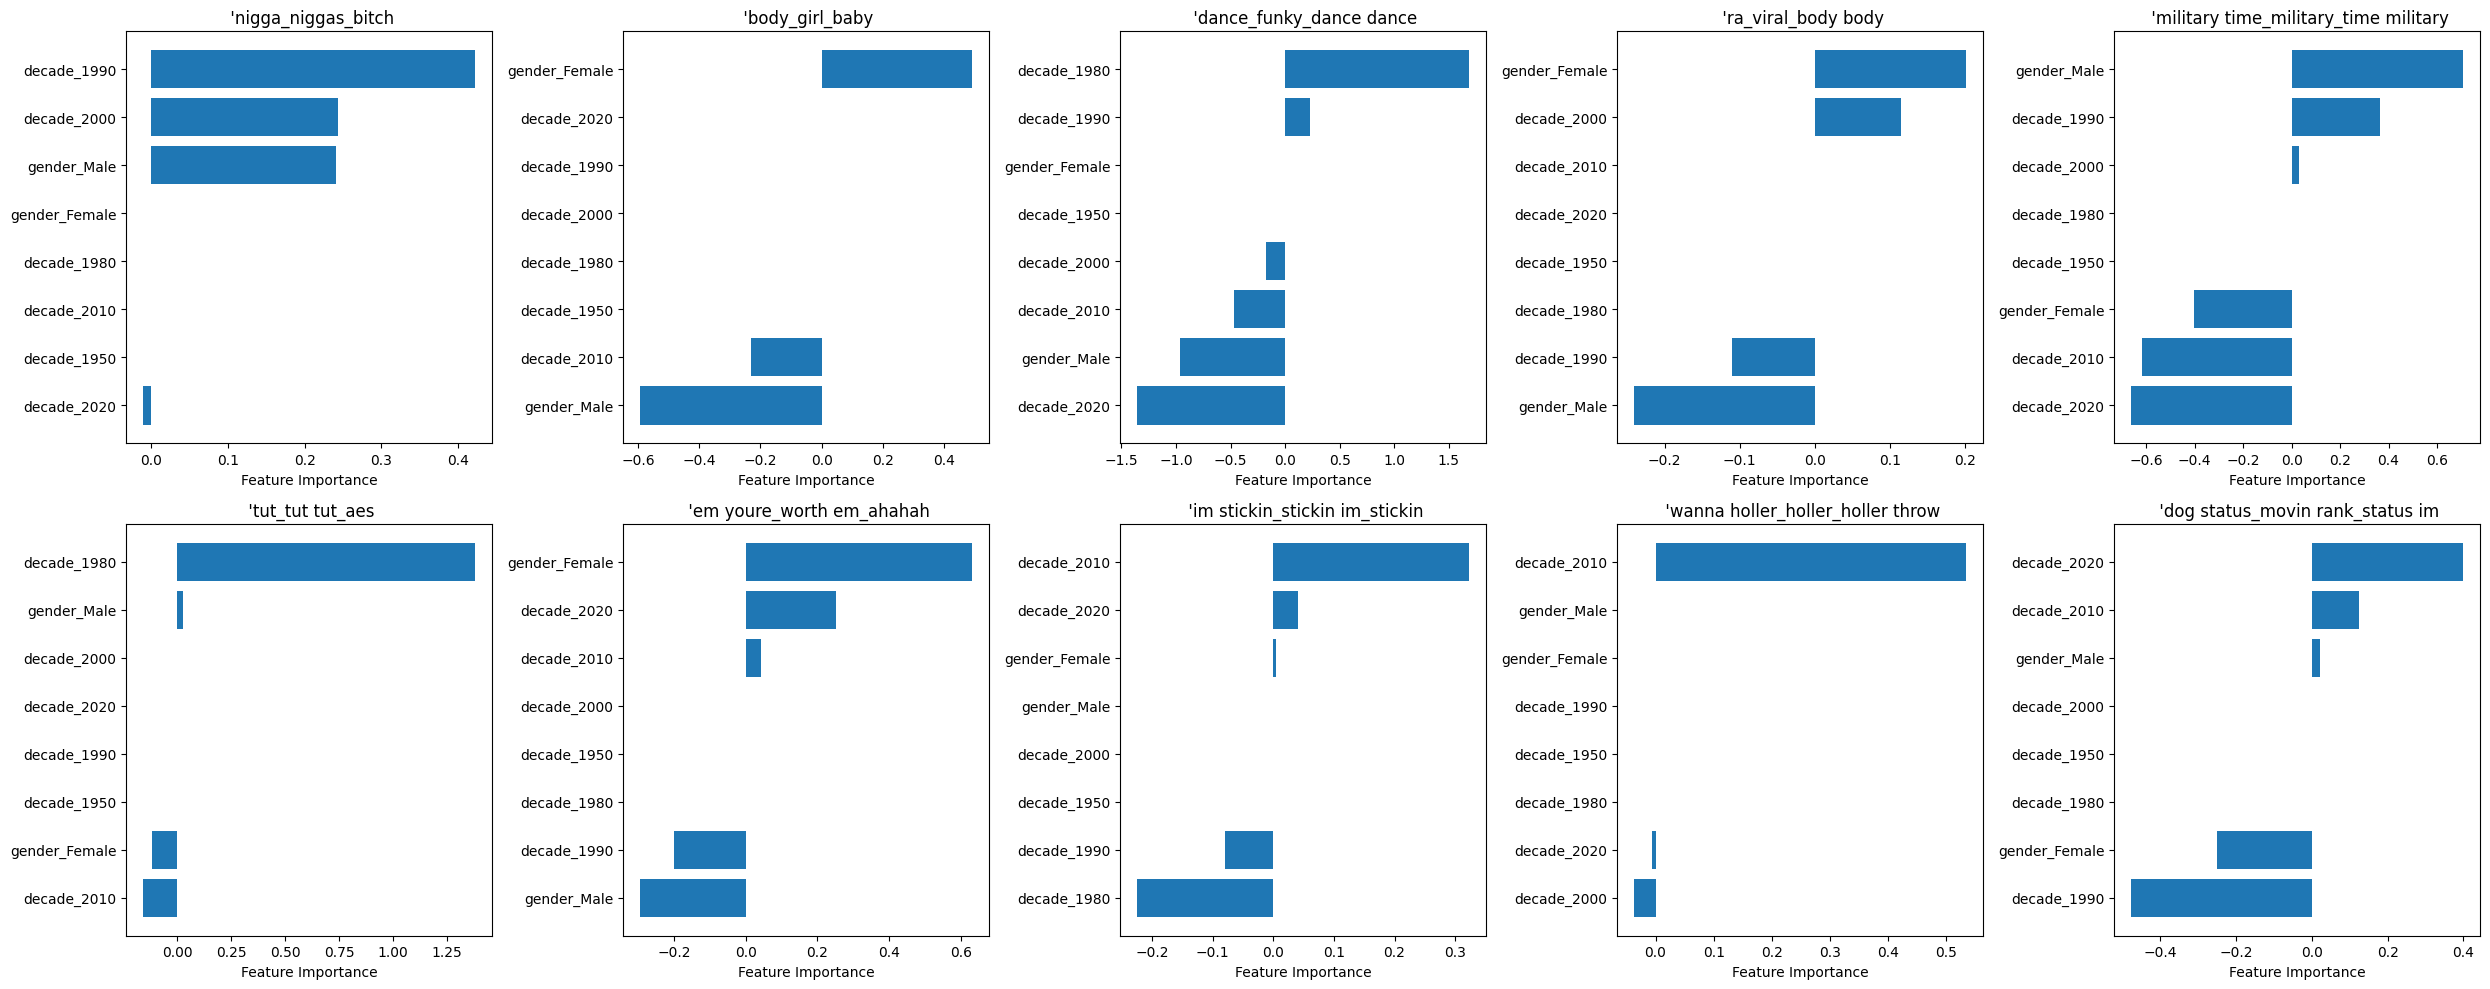

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create a bar chart for feature importances
def plot_feature_importances(importances, names, title, top_n=10, ax=None):
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Get the top 'top_n' feature names and importances
    top_feature_names = [names[i] for i in indices[:top_n]]
    top_importances = [importances[i] for i in indices[:top_n]]

    # Create a horizontal bar chart on the specified axes
    ax.barh(range(top_n), top_importances, align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_feature_names)
    ax.set_xlabel('Feature Importance')
    ax.set_title(title)
    ax.invert_yaxis()  # Invert the y-axis to show the most important features at the top

# Create a figure with subplots in a 2x5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10)) # Adjust the figure size as needed
fig.tight_layout(pad=5.0) # Add space between plots

# Assuming 'coefficients' is a 2D array with one row per class and 'feature_names' is a list of feature names
for class_index in range(coefficients.shape[0]):
    # Calculate the row and column index for the current subplot
    row_index = class_index // 5
    column_index = class_index % 5
    topic_label = topic_to_label.get(class_names[class_index])
    # Set top_n to the number of features or a smaller value if desired
    top_n = min(10, len(feature_names))

    # Plot feature importances for the current class
    plot_feature_importances(
        importances=coefficients[class_index],  # Use the coefficients for the current class
        names=feature_names,
        title=f" '{topic_label}",
        top_n=top_n,
        ax=axes[row_index, column_index]  # Pass the current axes to the plot function
    )

# Adjust subplots to fit the figure area
plt.tight_layout()

# Display the figure with subplots
plt.show()


In [ ]:
parameters = model.get_params()
parameters

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
coefficients = model.coef_
coefficients

array([[ 0.        ,  0.        ,  0.4227818 ,  0.24347591,  0.        ,
        -0.01127503,  0.        ,  0.24136652],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.22940557,
         0.        ,  0.49332336, -0.59441833],
       [ 0.        ,  1.68995226,  0.23109895, -0.17782962, -0.46573053,
        -1.35871784,  0.        , -0.96053705],
       [ 0.        ,  0.        , -0.11038365,  0.1141025 ,  0.        ,
         0.        ,  0.20132141, -0.24097532],
       [ 0.        ,  0.        ,  0.36587078,  0.03249045, -0.61656322,
        -0.66340639, -0.40095919,  0.70878971],
       [ 0.        ,  1.38313565,  0.        ,  0.        , -0.16085837,
         0.        , -0.11744636,  0.02348829],
       [ 0.        ,  0.        , -0.19895089,  0.        ,  0.04139955,
         0.25272819,  0.63184798, -0.29528442],
       [ 0.        , -0.22521683, -0.07975061,  0.        ,  0.32350268,
         0.04137616,  0.00433056,  0.        ],
       [ 0.        ,  0.        

In [ ]:
#extracting the feature weight for gender varaible

model.fit(X_train, y_train)

# Get the feature names after OneHotEncoding
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()

# Find the column indices for the 'gender' feature
gender_feature_indices = [i for i, feature in enumerate(feature_names) if 'gender' in feature]

# Extract the coefficients for the 'gender' feature from the model
gender_coefficients = model.coef_[:, gender_feature_indices]

# Print the gender coefficients
print(gender_coefficients)


[[ 0.          0.241591  ]
 [ 0.49481492 -0.59270412]
 [ 0.         -0.96033653]
 [ 0.18761143 -0.25446558]
 [-0.56452014  0.54545089]
 [ 0.          0.14123996]
 [ 0.61719051 -0.30972083]
 [ 0.00406859  0.        ]
 [ 0.          0.        ]
 [-0.26786671  0.00327564]]


Improvement on regression model: hyper parameter tuning


In [ ]:
# Print the number of unique classes
print("Number of unique classes:", len(top10_y.unique()))

# Print the count of instances in each class
print("Count of instances in each class:\n", top10_y.value_counts())


Number of unique classes: 10
Count of instances in each class:
 0      3106
261     430
2       326
66      320
98      285
101     223
272     187
398     153
357     148
3       141
Name: topic, dtype: int64


In [ ]:
# # Extracting the coefficients
# coefficients = best_model.coef_
# coefficients

# # Mapping coefficients to feature names
# coef_dict = dict(zip(feature_names, coefficients))

# # Extract and analyze coefficients related to 'gender'
# gender_coefs = {k: v for k, v in coef_dict.items() if 'gender' in k}
# print(gender_coefs)

# # Further steps would be to evaluate the model and interpret these coefficients.